In [34]:
import json
import numpy as np

firs = ""

with open('fir.json', 'r') as f:
    firs = json.load(f)

# for every entry check NAME and coordinates of FIR
for fir in firs['features']:
    name = "FIR"+fir['properties']['name']
    # extract all coordinates for
    coords = fir['geometry']['coordinates'][0]
    arr = np.array(coords)
    arr.T[[0,1]] = arr.T[[1,0]]
    c = np.round(arr.flatten(),4)
    print(' '.join(map(str,c)))
    print(name, end=' ')
    # print(np.array2string(c)[1 : -1])
    print(np.array2string(np.round(arr.flatten(),4))[1 : -1])

# print(json.dumps(firs, indent=4, sort_keys=True))

7.0 103.0 10.0 102.25 11.6481 102.9202 11.746 102.917 12.1726 102.7156 12.4061 102.7922 12.6926 102.5063 13.0167 102.5 13.2978 102.3516 13.575 102.3712 13.577 102.5676 13.7636 102.7275 14.2013 102.9613 14.2926 103.0927 14.4089 103.5327 14.3329 104.0238 14.4006 104.2057 14.3447 104.4768 14.4343 104.8053 14.336 105.2132 14.4153 105.4327 14.5528 105.5351 14.8011 105.5142 14.9984 105.5838 15.123 105.4686 15.3132 105.584 15.6578 105.6378 15.8008 105.3994 16.0132 105.414 16.1176 105.0518 16.2493 105.0124 16.5659 104.7377 17.0171 104.7333 17.254 104.8198 17.5429 104.689 17.6672 104.4669 18.1169 104.1068 18.3055 104.005 18.3445 103.7008 18.4375 103.5137 18.4357 103.3147 18.1356 103.0876 17.8716 102.6904 18.0582 102.2928 18.2197 102.0844 18.0269 101.8923 17.5957 101.267 17.4668 101.1666 17.5721 100.9601 17.8895 101.0249 18.0978 101.17 18.3423 101.18 18.4288 101.0581 18.697 101.2705 19.1282 101.2586 19.3498 101.2089 19.6028 101.2465 19.6286 100.893 19.5128 100.7566 19.5449 100.4926 19.7469 100.4

In [35]:
import rdp as RDP
import numpy as np


pos = np.array([
    [1,1], 
	[2,2],
	[3,3],
	[7,27],
	[10,10]
	])

anchors = [0, len(pos)-1]

RDP.simplify(pos, .1, anchors)

print(anchors)

[0, 2, 3, 4]


In [15]:

# provides distance in m
def mercator(lats, lons):
    r_major = 6378137.000
    x = r_major * np.radians(lons)
    scale = x/lons
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + lats * (np.pi/180.0)/2.0)) * scale
    return (x, y)

lats = np.asarray([63])
lons = np.asarray([179])

# lats = df['latitude'].values
# lons = df['longitude'].values

xs, ys = mercator(lats, lons)
# # df['latitude'].values

# df



print('xs: {}'.format(xs))  # => [-355520.27851004 -244902.8797452 ]
print('ys: {}'.format(ys))  # => [ 7358781.82857011  7558415.65608178]

# df

xs: [19926188.85199597]
ys: [9100250.90705955]


In [16]:
import pyproj
from pyproj import Transformer

# wgs84 =pyproj.CRS("EPSG:4326")
# merc  =pyproj.CRS("EPSG:3857")
# isn2004=pyproj.CRS("+proj=lcc +lat_1=64.25 +lat_2=65.75 +lat_0=65 +lon_0=-19 +x_0=1700000 +y_0=300000 +no_defs +a=6378137 +rf=298.257222101 +to_meter=1") 
 

lat = [63]   # x
lon = [179]  # y

wgs2merc = Transformer.from_crs("epsg:4326", "epsg:3857")
x, y = wgs2merc.transform(lat, lon)

print(x)
print(y)

merc2wgs = Transformer.from_crs("epsg:3857", "epsg:4326")
lat, lon = merc2wgs.transform(x, y)

print(lat)
print(lon)

[19926188.85199597]
[9100250.907059548]
[63.0]
[179.0]


In [17]:
import rdp as RDP
import lzma
import pandas as pd
import numpy as np
from io import StringIO
from pyproj import Transformer

n = 0
header = ""
oldId = ""
csv = ""

dfs = ""
dfs_raw = ""

wgs2merc = Transformer.from_crs("epsg:4326", "epsg:3857")
merc2wgs = Transformer.from_crs("epsg:3857", "epsg:4326")

with lzma.open("c:\\Users\\mschultz\\Downloads\\t_future_flas_360_ats_01.csv.xz", mode='rt', encoding='utf-8') as file:
    for line in file:
        id = line.split(sep=",")[0]
        if oldId != id:
            if(n > 1):  # ignore header
                print(header.split(sep=","))
                # print(csv)
                csvStringIO = StringIO(csv)
                df = pd.read_csv(csvStringIO, sep=",", header=None, names=header.split(sep=","))

                # df.to_csv("SIA.csv")

                # check for later: https://github.com/SciTools/cartopy/issues/368
                # https://stackoverflow.com/questions/65872151/geopandas-how-to-output-longitude-latitude-scale-correctly-in-mercator-projeti
                df['latitude_m'], df['longitude_m'] = wgs2merc.transform(df['latitude'], df['longitude'])

                # check weather flight is going over pacific
                isCross = abs(df['longitude'].values[0] - df['longitude'].values[-1]) > 180

                # create a reference set
                # TODO: correct data should indicate dateline change, isCross should not be necessary
                if isCross:
                    pos = df[df['longitude'] <= 0][['latitude_m','longitude_m']].to_numpy()
                    anchors = RDP.simplify(pos, 50, [0, len(pos)-1])
                    offSet = df[df['longitude'] > 0].index[0]
                    pos = df[df['longitude'] > 0][['latitude_m','longitude_m']].to_numpy()
                    anchors.extend(RDP.simplify(pos, 50, [0, len(pos)-1])+offSet)
                    # print (anchors)
                else:
                    pos = df[['latitude_m','longitude_m']].to_numpy()
                    anchors = RDP.simplify(pos, 50, [0, len(pos)-1])
                dfs_raw = df.loc[anchors] # 0.00001


                # simplify altitudes first, 25ft
                pos = df[['time','altitude']].to_numpy()
                anchors = RDP.simplify(pos, 25, [0, len(pos)-1])  

                # next step is simplify for distances, 200m
                # 0°: 1° => 111,13 km
                # 60°: 1° => 55,57 km
                # 0.003° set as equivalent for 200m
                # using lat and lon (degrees) by purpose, may be changed to mercator later
                pos = df[['latitude','longitude']].to_numpy()
                anchors = RDP.simplify(pos, .003 , anchors) # .003
                dfs = df.loc[anchors]


                break
            elif(n == 0):
                # add header without \\\ at the end
                header = str(line[:-1])
            csv = ""
            n += 1
        csv += str(line)

        oldId = id


['id', 'time', 'altitude', 'longitude', 'latitude']


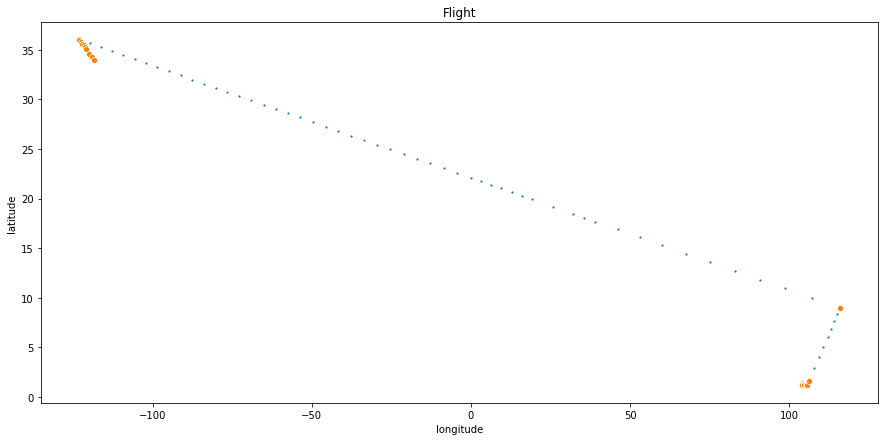

In [18]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 7))

chart = sns.lineplot(
    x="longitude",
    y="latitude",
    marker = '.',
    linestyle='',
    data=dfs_raw
).set_title('Flight')

chart = sns.lineplot(
    x="longitude",
    y="latitude",
    marker = 'o',
    linestyle='',
    data=dfs
).set_title('Flight')

# plt.xlim(95,120)
# plt.ylim(-5,10)

plt.show();

In [38]:
import geopandas

In [8]:
dfs

,id,time,altitude,longitude,latitude,latitude_m,longitude_m
0,SIA37A,-57081,0,-118.40778,33.94250,-1.318109e+07,4.021084e+06
492,SIA37A,-56589,17401,-119.11849,34.27435,-1.326021e+07,4.065700e+06
849,SIA37A,-56232,26144,-119.88633,34.62536,-1.334569e+07,4.113085e+06
1273,SIA37A,-55808,33193,-120.90301,35.07822,-1.345886e+07,4.174516e+06
1476,SIA37A,-55605,35876,-121.39418,35.29218,-1.351354e+07,4.203658e+06
1625,SIA37A,-55456,37235,-121.75366,35.44681,-1.355356e+07,4.224768e+06
1797,SIA37A,-55284,38377,-122.17051,35.62403,-1.359996e+07,4.249011e+06
1988,SIA37A,-55093,39270,-122.63587,35.81926,-1.365176e+07,4.275780e+06
2206,SIA37A,-54875,40000,-123.16971,36.03983,-1.371119e+07,4.306103e+06
50985,SIA37A,-6096,39982,115.88247,8.96816,1.289998e+07,1.002433e+06


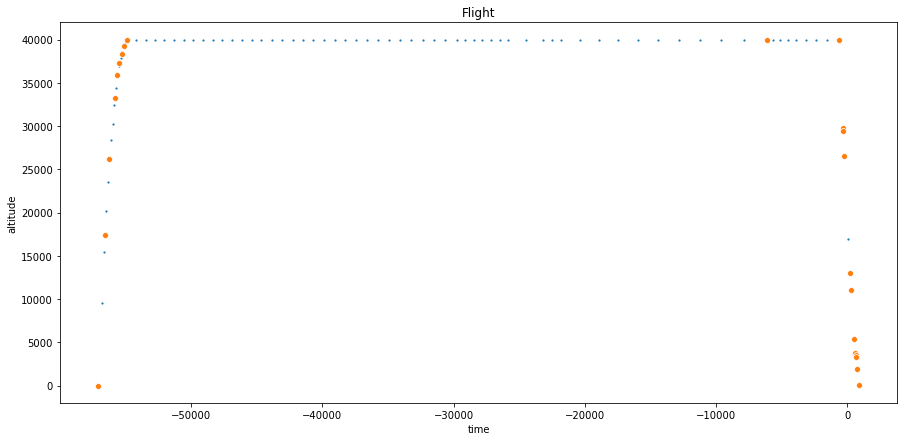

In [20]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 7))

chart = sns.lineplot(
    x="time",
    y="altitude",
    marker = '.',
    linestyle='',
    data=dfs_raw
).set_title('Flight')

chart = sns.lineplot(
    x="time",
    y="altitude",
    marker = 'o',
    linestyle='',
    data=dfs
).set_title('Flight')

# plt.xlim(95,120)
# plt.ylim(-5,10)

plt.show()

In [107]:
dfs

# resample https://kanoki.org/2020/04/14/resample-and-interpolate-time-series-data/
# https://stackoverflow.com/questions/41854578/using-pandas-dataframe-interpolate-to-add-rows-to-dataframe#comment70893217_41854682


,id,time,altitude,longitude,latitude,latitude_m,longitude_m
0,SIA37A,-57081,0,-118.40778,33.94250,-1.318109e+07,4.021084e+06
492,SIA37A,-56589,17401,-119.11849,34.27435,-1.326021e+07,4.065700e+06
849,SIA37A,-56232,26144,-119.88633,34.62536,-1.334569e+07,4.113085e+06
1273,SIA37A,-55808,33193,-120.90301,35.07822,-1.345886e+07,4.174516e+06
1476,SIA37A,-55605,35876,-121.39418,35.29218,-1.351354e+07,4.203658e+06
1625,SIA37A,-55456,37235,-121.75366,35.44681,-1.355356e+07,4.224768e+06
1797,SIA37A,-55284,38377,-122.17051,35.62403,-1.359996e+07,4.249011e+06
1988,SIA37A,-55093,39270,-122.63587,35.81926,-1.365176e+07,4.275780e+06
2206,SIA37A,-54875,40000,-123.16971,36.03983,-1.371119e+07,4.306103e+06
3432,SIA37A,-53649,39999,-117.16143,35.35941,-1.304235e+07,4.212831e+06


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

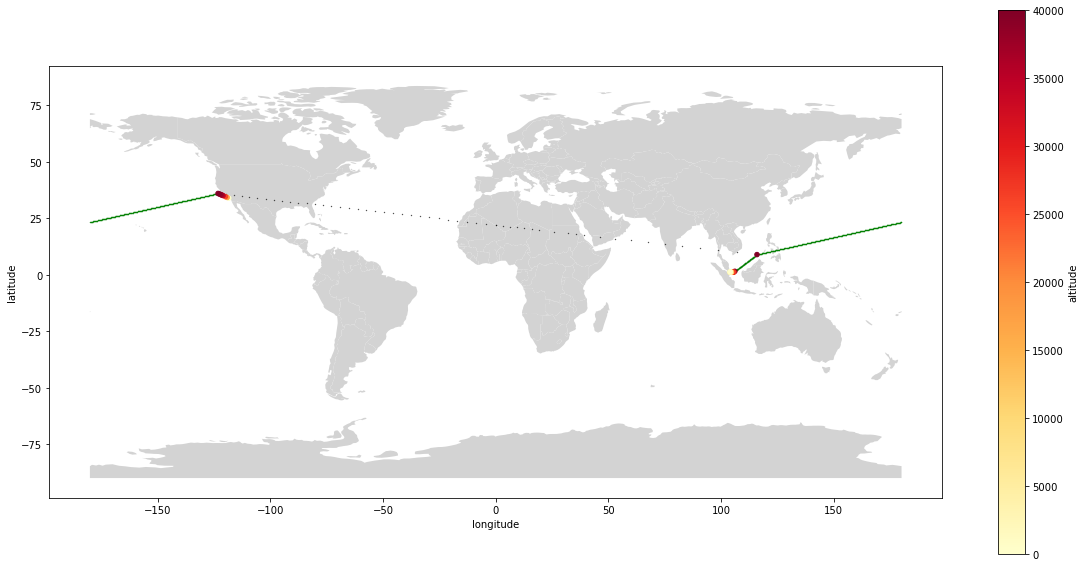

In [27]:
from itertools import count
import geopandas as gp


# initialize an axis
fig, ax = plt.subplots(figsize=(20,10))

# ax.set(xlim=(70,150), ylim=(-20, 30))
# ax.set(xlim=(90,130), ylim=(-15, 25))

countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)

dfs_raw.plot(x="longitude", y="latitude", kind="scatter", c = "black", s=.1, ax=ax)
dr.plot(x="longitude", y="latitude", kind="scatter", c = "green", s=.1, ax=ax)
dfs.plot(x="longitude", y="latitude", kind="scatter", c="altitude", colormap= "YlOrRd", ax=ax)



In [96]:
# get a copy of simplified dataframe
dr = dfs.copy()

# set a give date to transform seconds to timestamp
ddt = 248054400   # 11.11.77 just for fun

# create a new column to store time (s) as date
dr['date'] = pd.to_datetime(dr['time']+ddt, unit='s', utc=True)

# set date as index to allow for interpolation
dr = dr.set_index('date')

# resample the original dataframe
# column ['id'] was deleted: --> non-numerical columns are removed in resample.
dr_ = dr.resample('60s').mean()

# it makes no sence for interpolation of these values
dr_ = dr_.drop(['speed','dir','latitude_m','longitude_m'], axis = 1)


# consider shortes way is via pacific by checking longitudinal distance
isLeft = abs(dr_['longitude'].max() - dr_['longitude'].min()) > 180

# change longitudinal coordinates ensuring correct interpolation
if isLeft:
    dr_['longitude'] = [ 360 + x if x < 0 else x for x in dr_['longitude']]
    dr_ = dr_.interpolate('linear')
    dr_['longitude'] = [ x - 360 if x > 180 else x for x in dr_['longitude']]

    # find closest point to dateline an add to dataset
    dr = pd.concat(
        [ dr, 
          # dr_[dr_['longitude'] == dr_['longitude'].min()], 
          dr_.loc[[str(dr_['longitude'].idxmin())]],   # [[]] double [[ is important
          dr_[dr_['longitude'] == dr_['longitude'].max()]
        ]
        ).sort_index()
    
    # cut the dataset in east and west
    east  = dr.loc[ : dr['longitude'].diff().idxmax()][:-1]
    east = dr_.interpolate('linear')
    west  = dr.loc[dr['longitude'].diff().idxmax() : ]

    east = east.resample('60s').mean()
    west = west.resample('60s').mean()
    print(east)

    # print(dr_.loc[dr_['longitude'].idxmin()])
    # print(dr_.loc[dr_['longitude'].idxmax()])




    # # remove all entry created, which are before first occurance and after last occurance
    # dr_ = dr_.loc[dr.index[0]:dr.index[-1]]

    # # join datasets
    # dr = pd.concat([dr, dr_]).sort_index()

    # dr = dr.ffill()


# dr.loc['1977-11-10 15:07:00+00:00']
dr

                                   time      altitude   longitude   latitude  \
date                                                                           
1977-11-10 08:08:00+00:00 -57081.000000      0.000000 -118.407780  33.942500   
1977-11-10 08:09:00+00:00           NaN           NaN         NaN        NaN   
1977-11-10 08:10:00+00:00           NaN           NaN         NaN        NaN   
1977-11-10 08:11:00+00:00           NaN           NaN         NaN        NaN   
1977-11-10 08:12:00+00:00           NaN           NaN         NaN        NaN   
...                                 ...           ...         ...        ...   
1977-11-10 15:03:00+00:00           NaN           NaN         NaN        NaN   
1977-11-10 15:04:00+00:00           NaN           NaN         NaN        NaN   
1977-11-10 15:05:00+00:00           NaN           NaN         NaN        NaN   
1977-11-10 15:06:00+00:00           NaN           NaN         NaN        NaN   
1977-11-10 15:07:00+00:00 -31955.469865 

,id,time,altitude,longitude,latitude,latitude_m,longitude_m,dist,dir,speed
date,,,,,,,,,,
1977-11-10 08:08:39+00:00,SIA37A,-57081.000000,0.000000,-118.407780,33.942500,-1.318109e+07,4.021084e+06,0.000000,299.619187,152.683148
1977-11-10 08:16:51+00:00,SIA37A,-56589.000000,17401.000000,-119.118490,34.274350,-1.326021e+07,4.065700e+06,75.120109,299.219134,225.491811
1977-11-10 08:22:48+00:00,SIA37A,-56232.000000,26144.000000,-119.886330,34.625360,-1.334569e+07,4.113085e+06,80.500577,298.782413,248.954429
1977-11-10 08:29:52+00:00,SIA37A,-55808.000000,33193.000000,-120.903010,35.078220,-1.345886e+07,4.174516e+06,105.556678,298.198714,249.169372
1977-11-10 08:33:15+00:00,SIA37A,-55605.000000,35876.000000,-121.394180,35.292180,-1.351354e+07,4.203658e+06,50.581383,297.915965,247.328025
1977-11-10 08:35:44+00:00,SIA37A,-55456.000000,37235.000000,-121.753660,35.446810,-1.355356e+07,4.224768e+06,36.851876,297.705506,247.420204
1977-11-10 08:38:36+00:00,SIA37A,-55284.000000,38377.000000,-122.170510,35.624030,-1.359996e+07,4.249011e+06,42.556275,297.463062,247.579686
1977-11-10 08:41:47+00:00,SIA37A,-55093.000000,39270.000000,-122.635870,35.819260,-1.365176e+07,4.275780e+06,47.287720,297.189776,247.532197
1977-11-10 08:45:25+00:00,SIA37A,-54875.000000,40000.000000,-123.169710,36.039830,-1.371119e+07,4.306103e+06,53.962019,296.637388,247.571139


In [48]:
dr = dfs.copy()

res = dr['longitude'].diff().idxmax()

res

50985

In [24]:
# vectorized haversine function
def distance(lat1: list, lon1: list, lat2 : list = None, lon2 : list = None) -> list:

    if lat2 is None:
        # lat = lat1.shift()
        # lon = lon1.shift()
        # lat2 = lat1[1:]
        # lon2 = lon1[1:]
        # lat1 = lat
        # lon1 = lon
        lat2 = lat1
        lon2 = lon1
        lat1 = lat1.shift()
        lon1 = lon1.shift()

    # for a,b,c,d in zip(lat1, lon1, lat2, lon2):
    #     print(str(a) + "\t" + str(b) + "\t" + str(c) + "\t" + str(d))

    # to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # pre calculation
    dLat = lat2-lat1
    dLon = lon2-lon1

    # normalized distance
    a = np.sin(dLat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2.0)**2

    # first value form NAN to 0
    a[0] = 0
    earth_radius = 6371

    # calculate distance
    dist = earth_radius * 2 * np.arcsin(np.sqrt(a))

    # calculate bearing 
    x = np.sin(dLon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dLon))
    brng = np.arctan2(x, y)
    brng = np.rad2deg(brng)
    
    # compass_bearing
    brng = ((brng) + 360) % 360  

    # set as course, fill NAN with 0 -- last row
    brng = brng.shift(-1).fillna(0)

    return dist, brng



def sec2time(sec):
   sec = sec % (24 * 3600)
   hour = sec // 3600
   sec %= 3600
   min = sec // 60
   sec %= 60
#    print("seconds value in hours:",hour)
#    print("seconds value in minutes:",min)
   return "%02d:%02d:%02d" % (hour, min, sec) 


dff = dfs

# dff['dist'] = distance(dff['latitude'].shift(), dff['longitude'].shift(), dff.loc[1:, 'latitude'], dff.loc[1:, 'longitude'])


dff['dist'], dff['dir'] = distance(dff['latitude'], dff['longitude'])

# set speed as value to achieve the distance before. Thus speed now contains the speed needed for the next leg.
dff['speed'] = (dff['dist']/dff['time'].diff()*1000).shift(-1).fillna(0)

# print(dff)

# find row which meets the criteria
f = dff[dff['time'] > 0].index[0]
# store all index in a list
indexList = dff.index.values.tolist()
# find row before -- take row 1 as minimum, since row 0 has no speed
i = max(1, indexList.index(f) - 1)
# access row and store at single list

d = dff.iloc[[i]].values.flatten().tolist()

# print(d)

# CRE acid type lat lon hdg alt spe
# CRE SIA37A A350 1.196620 105.570520 268.3 29798 247.4
dt = d[1]
print( str(sec2time(0))+">CRE", d[0], "A350 %5.6f %5.6f %5.1f %5.0f %5.1f" % (d[4], d[3], d[6], d[2], d[7]))

# https://github.com/TUDelft-CNS-ATM/bluesky/wiki/addwpt
# The speed at each waypoint is the speed for the leg towards this waypoint.
# 00:00:01.11>ADDWPT,AC0001,-3.24887465,-2.77108288,0.0,450.00000000

# all other postions are taken as waypoints
for c in range(i+1, len(indexList)):
    d = dff.iloc[[c]].values.flatten().tolist()
    print(str(sec2time(0))+">ADDWPT", d[0], "%5.6f %5.6f %5.1f %5.1f" % (d[4], d[3], d[2], d[7]))

# dff



00:00:00>CRE SIA37A A350 1.185770 105.381660 132008.7 26566  18.8
00:00:00>ADDWPT SIA37A 1.166530 104.573090 13053.0  89.9
00:00:00>ADDWPT SIA37A 1.163830 104.452950 11096.0  13.4
00:00:00>ADDWPT SIA37A 1.138760 104.111300 5405.0  38.1
00:00:00>ADDWPT SIA37A 1.131550 104.012400 3790.0  11.0
00:00:00>ADDWPT SIA37A 1.135680 103.999390 3556.0   1.5
00:00:00>ADDWPT SIA37A 1.150270 103.991350 3280.0   1.9
00:00:00>ADDWPT SIA37A 1.235110 103.990430 1920.0   9.4
00:00:00>ADDWPT SIA37A 1.358780 103.989170   4.0  13.8
